<a href="https://colab.research.google.com/github/andreac941/tutorials/blob/main/TC5033_Activity3b_ID01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Word Embeddings
### **Team 1**:
- Alexis Hernández Martínez A01016308
- Rigoberto Vega Escudero A01793132
- Rodrigo Rodríguez Rodríguez A01183284
- Andrea Carolina Treviño Garza A01034993

<br>

### **Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch**
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy function (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confusion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
# Installation of requirements:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
!pip install scikit-plot

In [2]:
# The following libraries are required for running the given code:
# Please feel free to add any libraries you consider adecuate to complete the assignment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
# Loading train & test dataset from AG_NEWS dataset
train_dataset, test_dataset = AG_NEWS()
# Converting iterable objects from dataset to mapping style
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [6]:
# Get the tokenizer
# tokenizer object, for getting the tokens (words) from a sentence:
tokeniser = get_tokenizer('basic_english')

# Function for producing the tokens fron a dataset
def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [7]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
# Set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [8]:
# Test the functions for creating tokens:
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [9]:
# Defining the number of examples for training and validation dataset
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [10]:
# Randomly splitting the training and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [11]:
# Printing the size of the train, validation and test dataset
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [12]:
# Function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long) - 1

In [13]:
# Defining the labels for the classes, the maximum amount of tokens & the batch size
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [14]:
# Loading the data of each dataset in batch sizes
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True, drop_last=True)

In [16]:
# Validating the sizes of each batch of texts and labels
text_batch, label_batch= next(iter(train_loader))
print(text_batch.shape)
print(label_batch.shape)
print(text_batch[-1, :].shape)
print(label_batch)

torch.Size([256, 50])
torch.Size([256])
torch.Size([50])
tensor([1, 0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 3, 2, 3, 0, 3, 1, 2, 0, 1, 1, 3,
        2, 0, 0, 3, 3, 2, 1, 1, 0, 1, 1, 3, 3, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2, 1,
        1, 1, 0, 2, 1, 1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1, 1, 2,
        2, 2, 0, 0, 2, 2, 2, 3, 1, 1, 2, 1, 3, 2, 2, 1, 2, 1, 3, 1, 2, 3, 2, 0,
        3, 3, 3, 0, 2, 2, 2, 1, 2, 0, 2, 3, 1, 0, 0, 2, 2, 0, 0, 3, 3, 0, 3, 3,
        2, 0, 1, 2, 2, 3, 2, 3, 3, 2, 2, 0, 0, 2, 1, 1, 3, 2, 3, 3, 1, 3, 3, 0,
        3, 1, 2, 1, 2, 2, 3, 3, 3, 0, 1, 1, 2, 3, 3, 0, 3, 3, 3, 2, 3, 3, 2, 0,
        3, 2, 2, 2, 1, 0, 2, 0, 0, 0, 1, 3, 2, 2, 0, 0, 3, 3, 3, 1, 1, 3, 1, 0,
        3, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 3, 1, 0, 3, 1, 2,
        0, 0, 0, 1, 2, 1, 3, 1, 2, 0, 3, 1, 1, 2, 0, 0, 3, 2, 3, 3, 2, 2, 1, 3,
        0, 0, 2, 2, 2, 0, 3, 3, 0, 0, 1, 0, 0, 2, 1, 2])


### Let us build our RNN model

In [17]:
# Defining the size of each Embedding, neurons size, hidden layers, and number of classes.
EMBEDDING_SIZE = 50
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 256

In [18]:
# Function for our RNN model
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)
        self.rnn = nn.LSTM(embed_size, hidden, layers, batch_first=True)
        self.fc =  nn.Linear(hidden, num_classes)

    #Forward pass:
    def forward(self, x):
        x = self.embedding_layer(x)
        out, _ = self.rnn(x)
        #print(y.shape)
        out = self.fc(out[:, -1])  # Using the last output of RNN for prediction
        return out

In [20]:
# Function for getting the accuracy of our model with each dataset
def accuracy(model, loader):
    # Validating that the model is in evaluation mode.
    model.eval()

    # Initializing counters:
    num_correct = 0
    num_samples = 0

    # Gradients aren't computed during evaluation.
    with torch.no_grad():
        for x, y in loader:
            # Data is moved to the same device as the model
            x, y = x.to(device), y.to(device)

            # Calculating model predictions.
            scores = model(x)
            _,predictions = scores.max(-1)
            #print(predictions)

            # Updating counters:
            num_correct += (predictions == y).sum()
            #print(num_correct)
            num_samples += predictions.size(0)

    # Calculating accuracy
    acc = num_correct / num_samples
    return acc

In [22]:
# Training function for our RNN model
def train(model, optimizer, epochs, loader, loss_fn=None):
    # In case that the loss function isn't given, we define CrossEntropyLoss by default.
    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss()

    # Validating that the model is in training mode.
    model.train()

    # Epoch loop:
    for epoch in range(epochs):
        # Initializing total_loss for each epoch
        total_loss = 0
        #print(epoch)
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            #print(outputs)
            loss = F.cross_entropy(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # Printing the average loss for each epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader)}')

In [23]:
# Definition of epoch and learning rate:
epochs = 10
lr = 1e-3
# Instantiating model & defining optimizer
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES).to(device)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)
rnn_model

RNN_Model_1(
  (embedding_layer): Embedding(95811, 50)
  (rnn): LSTM(50, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=256, bias=True)
)

In [ ]:
train(rnn_model, optimiser,epochs, train_loader)

Epoch 1/10, Loss: 1.4519251024354949
Epoch 2/10, Loss: 0.9375282277545567
Epoch 3/10, Loss: 0.4026764198040452
Epoch 4/10, Loss: 0.2919582261608785
Epoch 5/10, Loss: 0.23450196525546546
Epoch 6/10, Loss: 0.1919069536685094
Epoch 7/10, Loss: 0.15960772611607849


In [ ]:
# Printing the accuracy of test and validation datasets:
print(f'Accuracy Test: {accuracy(rnn_model, test_loader)*100:.4f} %')
print(f'Accuracy Val: {accuracy(rnn_model, val_loader)*100:.4f} %')

Accuracy Test: 90.2883 %
Accuracy Val: 90.3957 %


In [ ]:
# Function for displaying a sample text, the true label from the text and the label predicted from our RNN model
def sample_text(model, loader, vocab, num_samples):
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predictions = torch.max(outputs, 1)

            # Convert tensor to list
            x = x.cpu().numpy().tolist()[:num_samples]
            y = y.cpu().numpy().tolist()[:num_samples]
            predictions = predictions.cpu().numpy().tolist()[:num_samples]
            itos = vocab.get_itos()

            # Convert token IDs back to words, and words to sentences
            text_samples = [' '.join([itos[token] for token in sentence if token < len(itos)]) for sentence in x]

            return text_samples, y, predictions

In [ ]:
# List of possible labels for classifying texts
classes = ["World", "Sports", "Business", "Sci/Tech"]

# Implementing the sample_text function on 5 texts from the training dataset
x_text, y, predictions = sample_text(rnn_model, train_loader, vocab, 5)

# Formatting the results of the 5 sample texts for better understanding
for i in range(len(x_text)):
    print(f"Text Sample {i+1}: {x_text[i]}")
    print(f"True Label: {y[i]} - {classes[y[i]]}")
    print(f"Predicted Label: {predictions[i]} - {classes[predictions[i]]}")
    print("-" * 80)

Text Sample 1: exo adds portal software to objectweb objectweb , a consortium focused on delivery of open source infrastructure technologies , announced tuesday that exo platform sarl has joined the consortium and that its enterprise portal solution ( eps ) will be hosted by objectweb . <unk> <unk> <unk> <unk> <unk> <unk>
True Label: 3 - Sci/Tech
Predicted Label: 3 - Sci/Tech
--------------------------------------------------------------------------------
Text Sample 2: update singapore st engineering 3q net 17 to s\$102 . 1m singapore ( dow jones ) --singapore technologies engineering ltd . ( s63 . sg ) reported a 17 rise in third-quarter net profit friday because of stronger earnings from its ship-repair and shipbuilding activities . <unk> <unk> <unk> <unk>
True Label: 2 - Business
Predicted Label: 2 - Business
--------------------------------------------------------------------------------
Text Sample 3: the ipod in perspective that #39 s the number of music players that apple compu

In [ ]:
# Importing aditional libraries for displaying the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Function for getting the predictions of a selected dataset.
def get_predictions(model, loader):
    # Validating model is in evaluation mode
    model.eval()
    # List for model predictions and labels
    all_preds = []
    all_labels = []

    # No gradient required
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            # Predictions and labels added to the end of each list
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return all_labels, all_preds

In [ ]:
# Function for plotting the confusion matrix of our RNN model predictions
def plot_confusion_matrix(model, loader):
    y_true, y_pred = get_predictions(model, loader)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

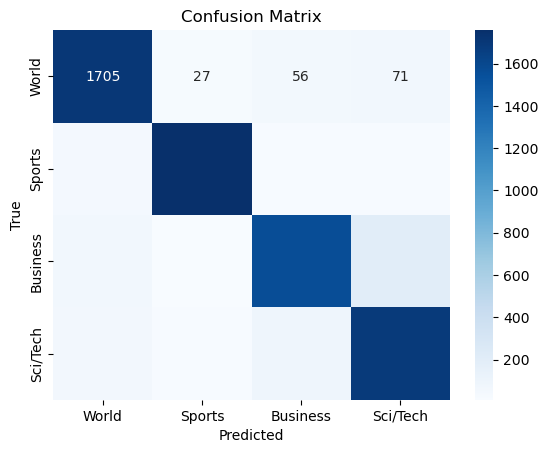

In [ ]:
# Plotting our confusion matrix with our model
plot_confusion_matrix(rnn_model, test_loader)

## Bibliography:
* Pepe Cantoral, Ph.D. (2023b, octubre 30). ¡LSTM: todo lo que necesitas saber! [Vídeo]. YouTube. https://www.youtube.com/watch?v=f6PaCo-NfJA
* First steps with SciKit-Plot — Scikit-Plot documentation. (s. f.). https://scikit-plot.readthedocs.io/en/stable/Quickstart.html
*